Comparison of `emcee` versus `zeus`

In [1]:
import os 
import h5py 
import time
import numpy as np 
import corner as DFM 

import emcee
import zeus
# --- gqp_mc ---
from gqp_mc import util as UT 
from gqp_mc import data as Data 
from gqp_mc import fitters as Fitters

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
# local directory where the MCMC files are stored
dir_mcmc = '/Users/ChangHoon/data/gqp_mc/mini_mocha/ispeculator/'

In [4]:
f = h5py.File(os.path.join(dir_mcmc, 'lgal.specphoto.noise_bgs0_legacy.emulator.4.postproc.hdf5'), 'r')
mcmc = {} 
for k in f.keys(): 
    mcmc[k] = f[k][...]

In [5]:
theta_in = mcmc['theta_med']
for name, tt_in in zip(mcmc['theta_names'], theta_in): 
    print('%s = %.1f' % (name, tt_in))

b'logmstar' = 10.2
b'beta1_sfh' = 0.3
b'beta2_sfh' = 0.5
b'beta3_sfh' = 0.0
b'beta4_sfh' = 0.2
b'gamma1_zh' = 0.0
b'gamma2_zh' = 0.0
b'tau' = 0.3
b'f_fiber' = 0.4
b'logsfr.100myr' = -0.4
b'logsfr.1gyr' = -0.3
b'logz.mw' = -2.9


(0.0, 25.0)

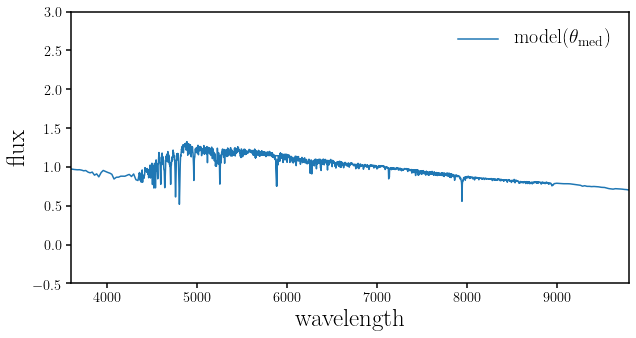

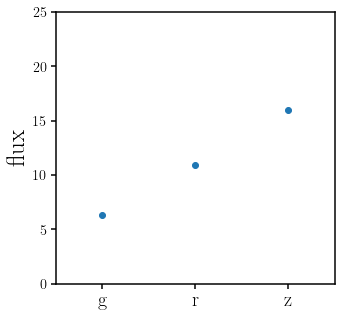

In [6]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(mcmc['wavelength_model'], mcmc['flux_spec_model'], 
         c='C0', label=r'model($\theta_{\rm med}$)')
sub.set_xlabel('wavelength', fontsize=25)
sub.set_xlim(3.6e3, 9800)
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim(-0.5, 3)
sub.legend(loc='upper right', fontsize=20)

fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.scatter(range(len(mcmc['flux_photo_model'])), mcmc['flux_photo_model'], color='C0')
sub.set_xticks([0, 1, 2])
sub.set_xticklabels(['g', 'r', 'z'], fontsize=20)
sub.set_xlim(-0.5, 2.5)
sub.set_ylabel('flux', fontsize=25)
sub.set_ylim(0., 25)

In [7]:
ifitter = Fitters.iSpeculator(model_name='emulator')

In [8]:
_mask = ifitter._check_mask('emline', mcmc['wavelength_model'], np.ones(len(mcmc['wavelength_model'])), mcmc['redshift'])

from speclite import filters as specFilter
bands_list = ifitter._get_bands('desi')
filters = specFilter.load_filters(*tuple(bands_list))

In [9]:
prior = ifitter._default_prior(f_fiber_prior=[theta_in[8]-0.1, theta_in[8]+0.1])
prior.min[1:5] = 0.
prior.max[1:5] = 1.

In [10]:
def logPosterior(tt): 
    return ifitter._lnPost_spectrophoto(
        tt, 
        mcmc['wavelength_model'], 
        mcmc['flux_spec_model'], 
        np.ones(len(mcmc['flux_spec_model'])), 
        mcmc['flux_photo_model'],
        np.ones(len(mcmc['flux_photo_model'])),
        mcmc['redshift'], 
        mask=_mask, filters=filters, prior=prior, dirichlet_transform=True)

In [11]:
nwalker = 100
ndim = 9
nsteps = 10000

In [12]:
# initial position for emcee
tt0 = [theta_in[:9] + 1.e-4 * (prior.max[:9] - prior.min[:9]) * np.random.randn(ndim) for i in range(nwalker)]

In [13]:
t0 = time.time() 
emcee_sampler = emcee.EnsembleSampler(nwalker, ndim, logPosterior)
pos, prob, state = emcee_sampler.run_mcmc(tt0, nsteps)
print('%.f sec' % (time.time() - t0))

/Users/ChangHoon/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]
/Users/ChangHoon/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/speclite/filters.py:1520: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  integrand = integrand[values_slice]


3071 sec


In [30]:
emcee_chain = emcee_sampler.get_chain(flat=True)

In [15]:
t0 = time.time()
zeus_sampler = zeus.sampler(nwalker, ndim, logPosterior)
zeus_sampler.run_mcmc(tt0, nsteps)
print('%.f sec' % (time.time() - t0))

Initialising ensemble of 100 walkers...
Sampling progress : 100%|██████████| 10000/10000 [7:06:28<00:00,  2.56s/it]  

25589 sec


In [16]:
zeus_sampler.summary

Summary
-------
Number of Generations: 10000
Number of Parameters: 9
Number of Walkers: 100
Number of Tuning Generations: 14
Scale Factor: 0.30742
Mean Integrated Autocorrelation Time: 197.76
Effective Sample Size: 5056.74
Number of Log Probability Evaluations: 5742735
Effective Samples per Log Probability Evaluation: 0.000881


In [31]:
zeus_chain = zeus_sampler.get_chain(flat=True)

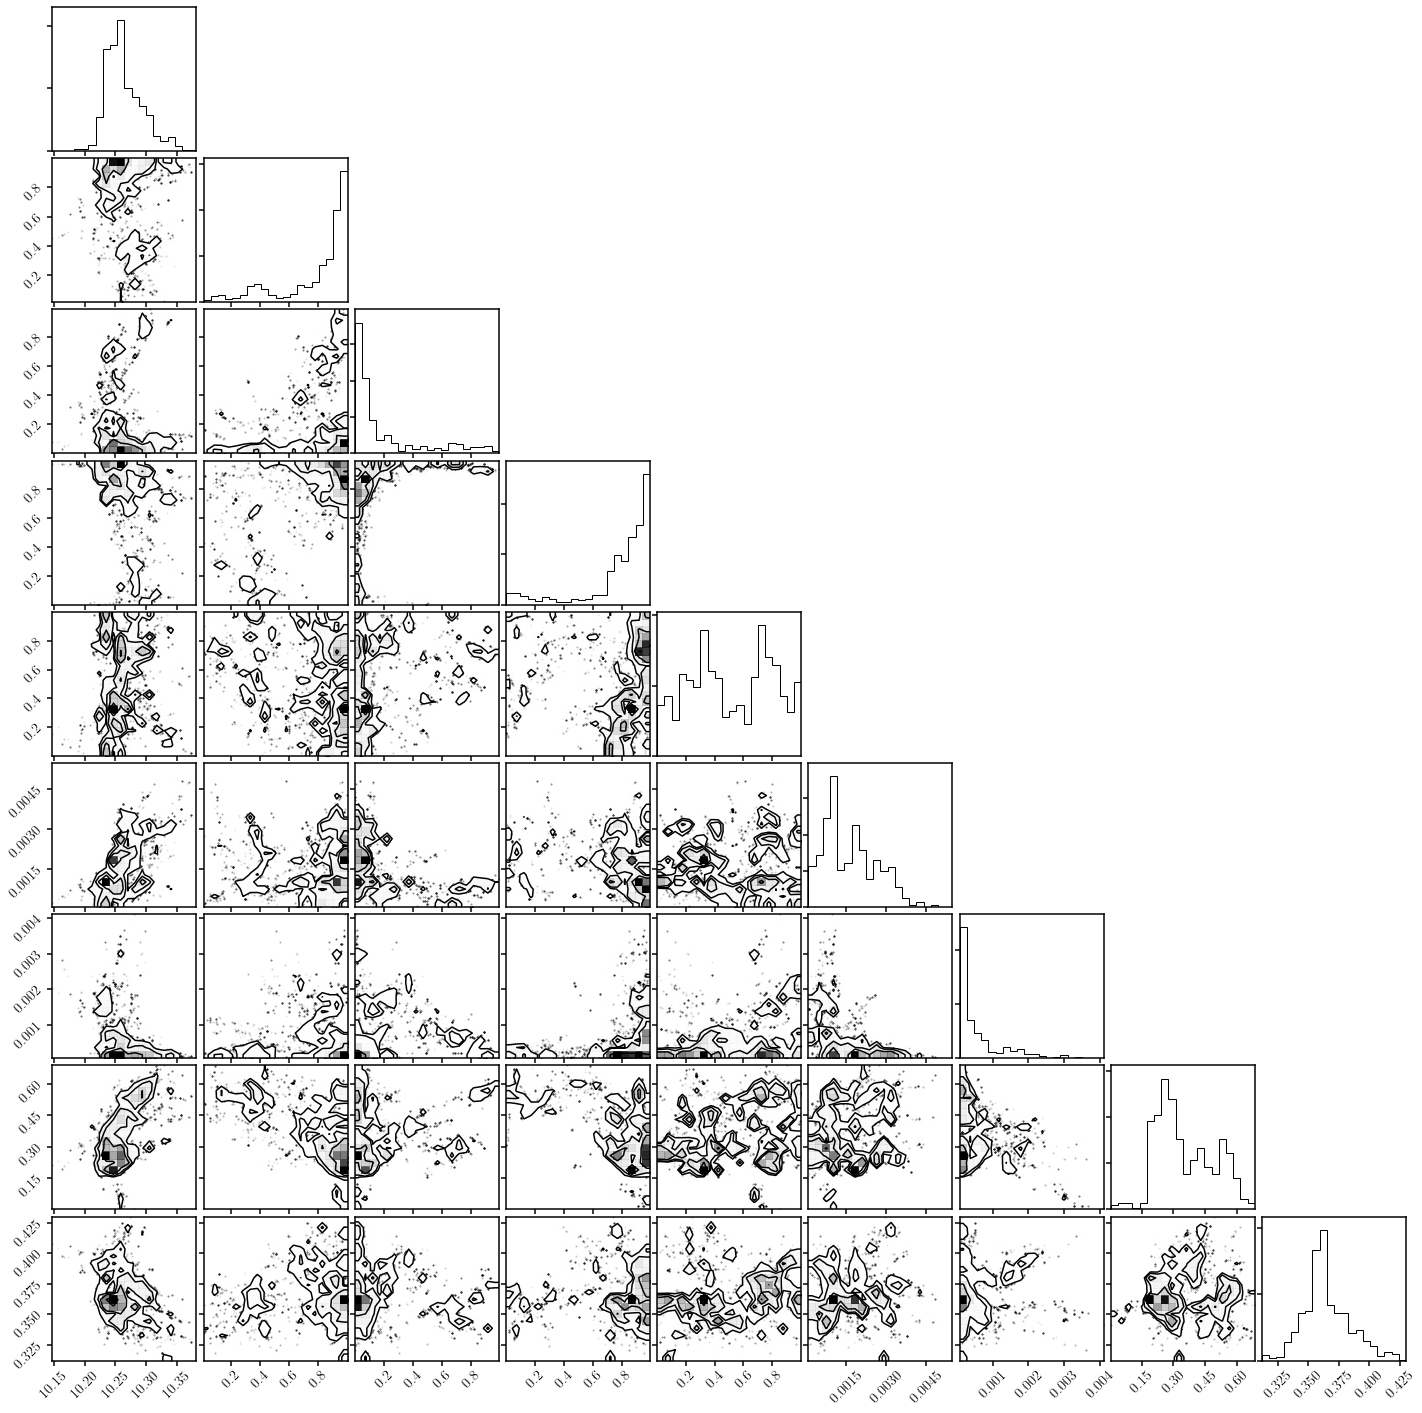

In [33]:
_ = DFM.corner(emcee_chain[::100])

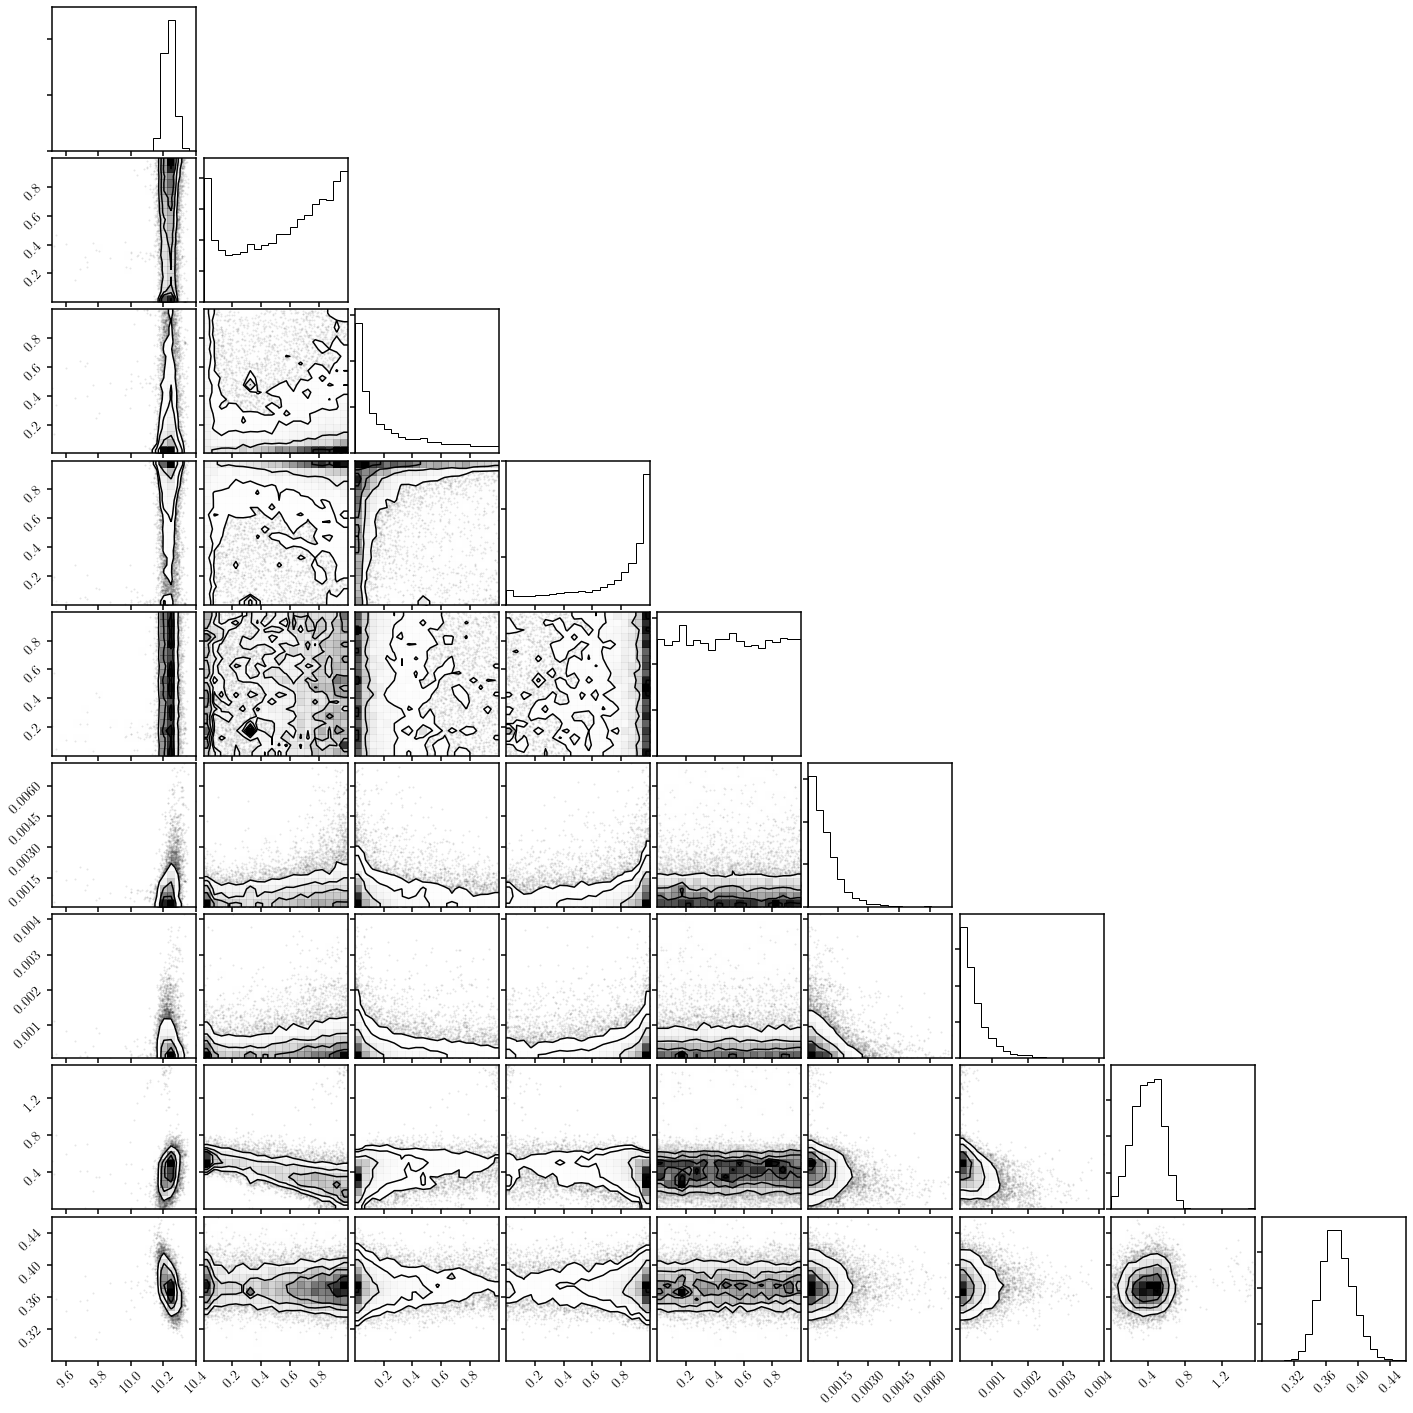

In [34]:
_ = DFM.corner(zeus_chain[::100])

Zeus takes significantly longer but the posteriors look much more converged... 

***revist this***